# Using only train folder

In [1]:
!pip install tensorflow --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 3.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 113.4 MB/s eta 0:00:0000:01
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.0
    Uninstalling tensorflow-2.19.0:
      Successfully uninstalled tensorflow-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.20.0 

In [2]:
# ==========================================================
# OBJECT DETECTION (BBOX REGRESSION) USING TRANSFER LEARNING
# DATASET: Only Train Folder Available
# METHOD: Train-Test Split (train / valid)
# MODEL: ResNet50 Backbone + BBox Regression (xmin,ymin,xmax,ymax)
# LABEL FORMAT: YOLO (class xc yc w h)
# ==========================================================


# ==========================================================
# 1. IMPORT LIBRARIES
# ==========================================================

import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


In [3]:
# ==========================================================
# 2. PATHS & SETTINGS
# ==========================================================

train_dir = "/kaggle/input/cardetection/car/train"   # only train folder
IMG_SIZE = 224

In [4]:
# ==========================================================
# 3. LOAD IMAGES + YOLO LABELS
# YOLO label format:
# class x_center y_center width height
# Convert to:
# xmin ymin xmax ymax  (normalized)
# If multiple objects exist, take the largest bbox
# ==========================================================

def load_images_and_bboxes(img_dir, label_dir, img_size=(224, 224)):
    images = []
    bboxes = []

    for filename in os.listdir(img_dir):

        if not filename.lower().endswith((".jpg", ".png", ".jpeg")):
            continue

        # ---- Load Image ----
        img_path = os.path.join(img_dir, filename)
        img = cv2.imread(img_path)

        if img is None:
            continue

        img = cv2.resize(img, img_size)
        img = img.astype("float32") / 255.0
        images.append(img)

        # ---- Label Path ----
        name, _ = os.path.splitext(filename)
        label_path = os.path.join(label_dir, name + ".txt")

        # ---- Read Label File ----
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                lines = f.readlines()

            if len(lines) > 0:
                best_bbox = None
                best_area = 0

                for line in lines:
                    parts = line.strip().split()

                    if len(parts) != 5:
                        continue

                    _, xc, yc, bw, bh = map(float, parts)

                    # YOLO -> xmin ymin xmax ymax
                    x_min = xc - bw / 2
                    y_min = yc - bh / 2
                    x_max = xc + bw / 2
                    y_max = yc + bh / 2

                    # Clip bbox inside image range
                    x_min = max(0, x_min)
                    y_min = max(0, y_min)
                    x_max = min(1, x_max)
                    y_max = min(1, y_max)

                    area = bw * bh

                    if area > best_area:
                        best_area = area
                        best_bbox = [x_min, y_min, x_max, y_max]

                if best_bbox is not None:
                    bboxes.append(best_bbox)
                else:
                    bboxes.append([0, 0, 0, 0])

            else:
                bboxes.append([0, 0, 0, 0])

        else:
            bboxes.append([0, 0, 0, 0])

    return np.array(images), np.array(bboxes)



In [5]:
# ==========================================================
# 4. LOAD DATA
# ==========================================================

X, y = load_images_and_bboxes(
    os.path.join(train_dir, "images"),
    os.path.join(train_dir, "labels"),
    img_size=(IMG_SIZE, IMG_SIZE)
)

print("Total Data:", X.shape, y.shape)




Total Data: (3530, 224, 224, 3) (3530, 4)


In [ ]:
# ==========================================================
# 5. VISUALIZE RANDOM IMAGE WITH BBOX
# ==========================================================

def show_random_bbox(images, bboxes):
    idx = random.randint(0, len(images) - 1)

    img = images[idx].copy()
    bbox = bboxes[idx]

    h, w = img.shape[:2]
    x_min, y_min, x_max, y_max = bbox

    x_min = int(x_min * w)
    y_min = int(y_min * h)
    x_max = int(x_max * w)
    y_max = int(y_max * h)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if x_max > x_min and y_max > y_min:
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 1, 0), 2)
    else:
        print("⚠️ Invalid bbox")

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Random Image Index: {idx}")
    plt.show()


print("\n--- Random Samples ---")
show_random_bbox(X, y)
show_random_bbox(X, y)


In [6]:
# ==========================================================
# 6. TRAIN / VALID SPLIT (because only train folder exists)
# ==========================================================

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Valid:", X_valid.shape, y_valid.shape)

Train: (2824, 224, 224, 3) (2824, 4)
Valid: (706, 224, 224, 3) (706, 4)


In [ ]:
# Custom CNN

# model = Sequential([
#     tf.keras.layers.Input(shape=(224, 224, 3)),

#     Conv2D(32, (3,3), activation='relu'),
#     MaxPooling2D(),

#     Conv2D(64, (3,3), activation='relu'),
#     MaxPooling2D(),

#     Conv2D(128, (3,3), activation='relu'),
#     MaxPooling2D(),

#     Flatten(),

#     Dense(256, activation='relu'),
#     Dropout(0.5),

#     Dense(4, activation='sigmoid')  # xmin,ymin,xmax,ymax
# ])

# model.compile(
#     optimizer=Adam(1e-4),
#     loss=tf.keras.losses.Huber(),
#     metrics=[tf.keras.metrics.MeanAbsoluteError()]
# )

# model.summary()


In [7]:
# ==========================================================
# 7. BUILD RESNET50 TRANSFER LEARNING MODEL (Functional API)
# ==========================================================

base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.4)(x)

outputs = Dense(4, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=tf.keras.losses.Huber(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

model.summary()


I0000 00:00:1770298684.049257      55 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1770298684.052227      55 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,638,852 (93.99 MB)

 Trainable params: 1,051,140 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [8]:
# ==========================================================
# 8. TRAIN MODEL
# ==========================================================

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=10,
    batch_size=32
)

Epoch 1/10
 2/89 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - loss: 0.0327 - mean_absolute_error: 0.2038  

I0000 00:00:1770298711.954770     165 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


89/89 ━━━━━━━━━━━━━━━━━━━━ 32s 224ms/step - loss: 0.0273 - mean_absolute_error: 0.1839 - val_loss: 0.0162 - val_mean_absolute_error: 0.1449
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - loss: 0.0197 - mean_absolute_error: 0.1579 - val_loss: 0.0139 - val_mean_absolute_error: 0.1346
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - loss: 0.0157 - mean_absolute_error: 0.1409 - val_loss: 0.0129 - val_mean_absolute_error: 0.1253
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - loss: 0.0139 - mean_absolute_error: 0.1305 - val_loss: 0.0119 - val_mean_absolute_error: 0.1203
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 0.0130 - mean_absolute_error: 0.1258 - val_loss: 0.0115 - val_mean_absolute_error: 0.1195
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 0.0127 - mean_absolute_error: 0.1225 - val_loss: 0.0110 - val_mean_absolute_error: 0.1147
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.0124 - mean_absolute_error: 0.1194 - val_loss: 0.0

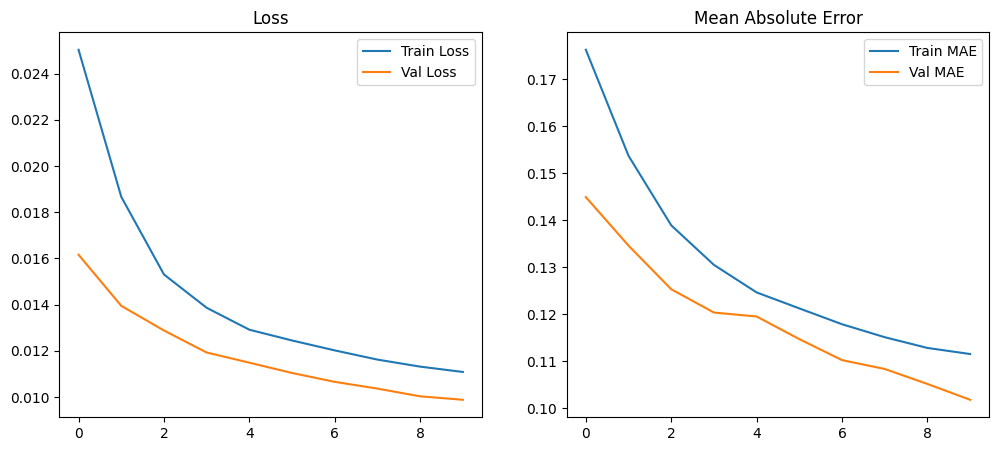

In [9]:
# ==========================================================
# 9. PLOT TRAINING GRAPH
# ==========================================================

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["mean_absolute_error"], label="Train MAE")
plt.plot(history.history["val_mean_absolute_error"], label="Val MAE")
plt.title("Mean Absolute Error")
plt.legend()

plt.show()


In [ ]:
# ==========================================================
# 10. SAVE MODEL (.h5)
# ==========================================================

# model.save("bbox_resnet_model.h5")
# print("✅ Model saved successfully as bbox_resnet_model.h5")

In [10]:
# ==========================================================
# 11. PREDICT + VISUALIZE ON ANY IMAGE
# ==========================================================

def predict_and_visualize(model, image_path):
    image = cv2.imread(image_path)

    if image is None:
        print("❌ Image not found:", image_path)
        return

    h, w = image.shape[:2]

    img_resized = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    img_norm = img_resized.astype("float32") / 255.0
    img_input = np.expand_dims(img_norm, axis=0)

    pred = model.predict(img_input, verbose=0)[0]
    print("Predicted (normalized):", pred)

    # Fix bbox ordering
    x1, y1, x2, y2 = pred
    x_min, x_max = min(x1, x2), max(x1, x2)
    y_min, y_max = min(y1, y2), max(y1, y2)

    # Convert normalized -> pixel
    x_min = int(x_min * w)
    y_min = int(y_min * h)
    x_max = int(x_max * w)
    y_max = int(y_max * h)

    # Clip bbox
    x_min = max(0, x_min)
    y_min = max(0, y_min)
    x_max = min(w, x_max)
    y_max = min(h, y_max)

    if x_max <= x_min or y_max <= y_min:
        print("⚠️ Invalid predicted bbox")
        return

    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

    plt.figure(figsize=(7, 7))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


--- Prediction on Random Train Image ---
Image Path: /kaggle/input/cardetection/car/train/images/00002_00004_00027_png.rf.7810d0a91d17cf7c416ecf32c000fe94.jpg
Predicted (normalized): [0.11147615 0.087358   0.91865176 0.94105965]


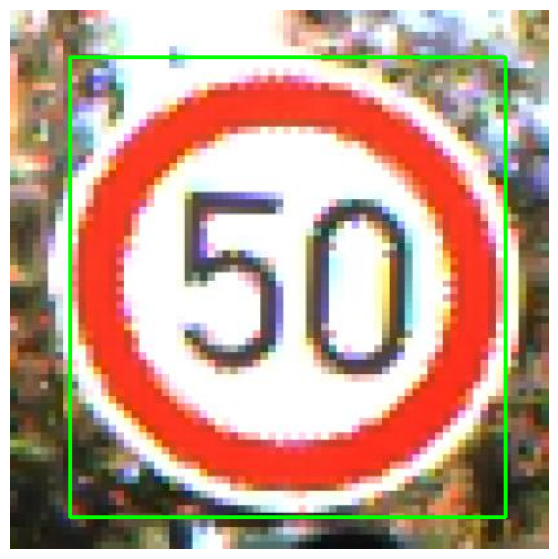

In [13]:
# ==========================================================
# 12. TEST ON RANDOM IMAGE FROM TRAIN FOLDER
# ==========================================================

train_images_dir = os.path.join(train_dir, "images")
random_img_name = random.choice(os.listdir(train_images_dir))
random_img_path = os.path.join(train_images_dir, random_img_name)

print("\n--- Prediction on Random Train Image ---")
print("Image Path:", random_img_path)

predict_and_visualize(model, random_img_path)

In [1]:
# 